In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False
1,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.7829,2,5,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          371      0.5310 0.2547   0.7029 0.5132   0.5148
Totals (Over/Under)  371      0.4825 0.2510   0.6952 0.5019   0.5256
Asian Handicap       371      0.7520 0.1917   0.5738 0.5073   0.7493


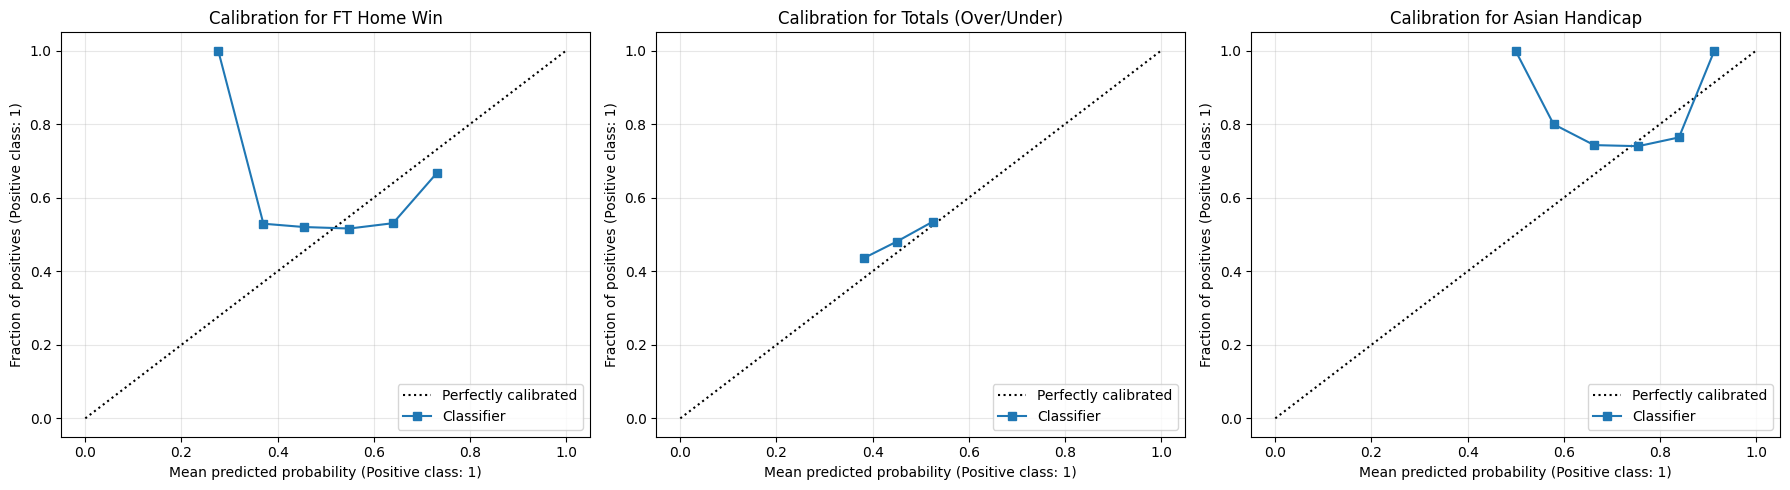

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=10)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          231      0.5325 0.2512   0.6951 0.5334   0.5108
Totals (Over/Under)  231      0.4892 0.2514   0.6959 0.4985   0.5065
Asian Handicap       231      0.7489 0.1961   0.5827 0.4840   0.7446


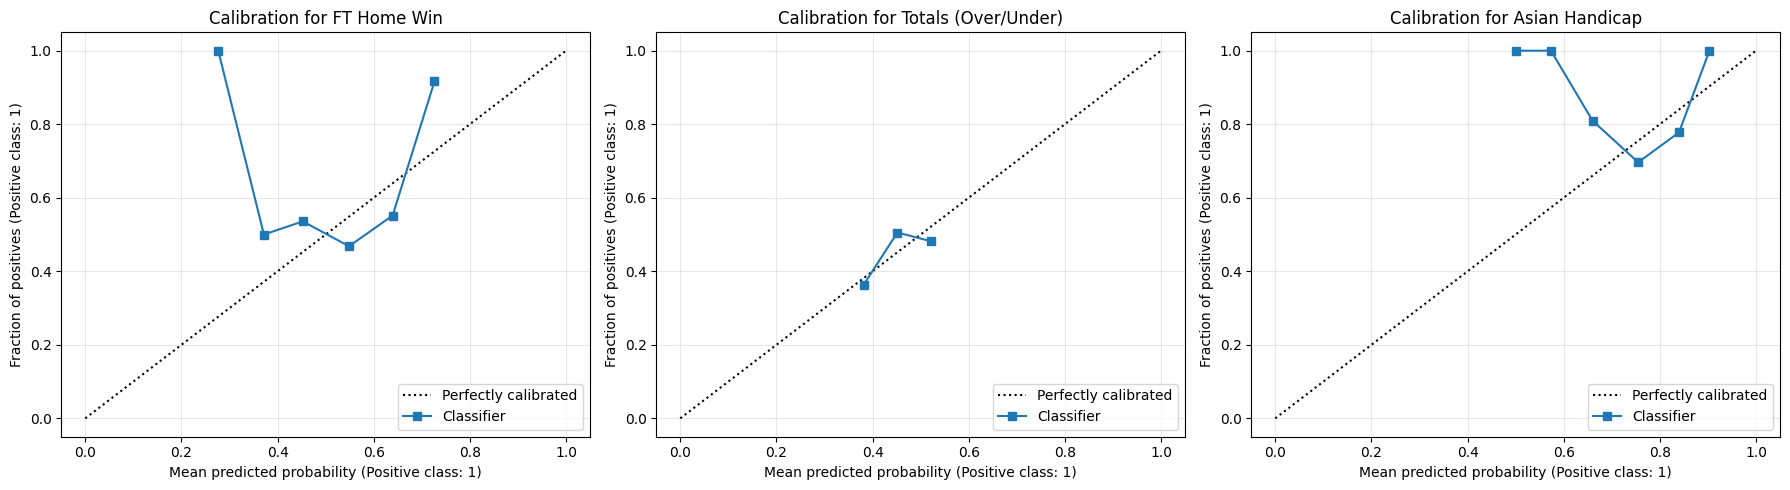

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=10)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500067,2025-11-27T03:00:00,Portland Trailblazers,San Antonio Spurs,0.5471,0.7181,0.7488,102,115,False,False,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          100      0.5400 0.2096   0.6065 0.7283   0.6300
Totals (Over/Under)  100      0.6000 0.2577   0.7224 0.5565   0.5900
Asian Handicap       100      0.7700 0.1420   0.4358 0.8063   0.8000


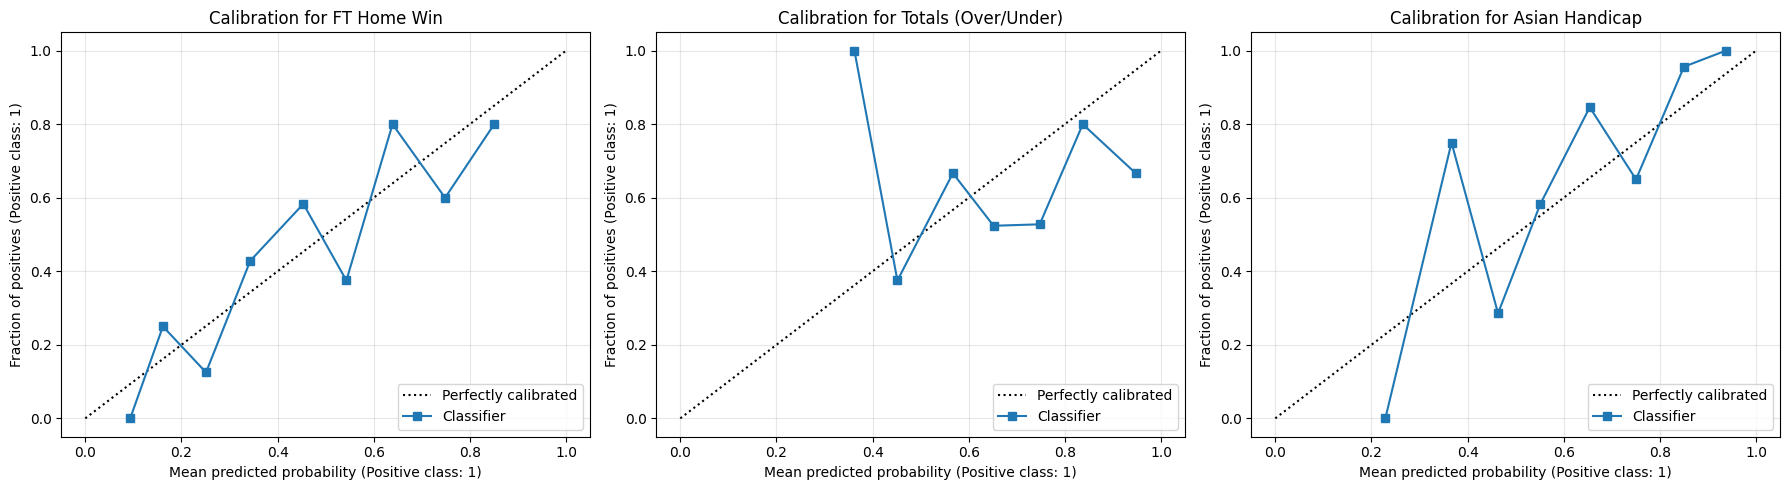

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=10)